In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
])

n=A.shape[0]



In [5]:
#volendo qui si può fare il controllo per caprire se basta trasporre A per ottere la amtrice M

#devo faree il controllo sulle somme righe e colorre
col_sums=A.sum(axis=0)
row_sums=A.sum(axis=1)

#PER ORA METTO IL CODICE DI CHAT 
tol = 1e-12
if np.all(np.abs(col_sums - 1) < 1e-10):
    print("Usiamo A così com'è (colonne sommano 1).")
    Ac = A.copy()
elif np.all(np.abs(row_sums - 1) < 1e-10):
    print("Le righe sommano 1: useremo A.T come matrice colonn-stocastica.")
    Ac = A.T.copy()
else:
    # normalizziamo colonne per colonna: se somma colonna = 0 -> dangling (lasciamo zero)
    print("Né colonne né righe sommano 1; normalizzo le colonne (lasciando dangling se somma=0).")
    Ac = A.copy()
    for j in range(n):
        s = Ac[:, j].sum()
        if s > tol:
            Ac[:, j] = Ac[:, j] / s
        else:
            # dangling column: la lasciamo a zero (gestiremo con teleportation)
            Ac[:, j] = 0.0

print("Matrice column-stochastic usata (Ac):")
display(pd.DataFrame(np.round(Ac,6)))

Usiamo A così com'è (colonne sommano 1).
Matrice column-stochastic usata (Ac):


,0,1,2,3,4
0,0.000000,0.0,0.5,0.5,0.0
1,0.333333,0.0,0.0,0.0,0.0
2,0.333333,0.5,0.0,0.5,1.0
3,0.333333,0.5,0.0,0.0,0.0
4,0.000000,0.0,0.5,0.0,0.0


In [6]:
m=0.15 
S=np.ones((n,n))/n
M=(1-m)*Ac + m*S

In [7]:
#CALCOLO AUTOVALORE STAZIONARIO q(AUTOVETTORE DI LAMBDA=1)

eigenvals, eigenvecs = np.linalg.eig(M)
index_max = np.argmax(np.abs(eigenvals - 1))
q_raw=eigenvecs[:, index_max].real

#valori assoluti perchè q non deve avere componenti negative e normalizzo 
q = np.abs(q_raw) / np.sum(np.abs(q_raw))

print("Autovalori di M:")
print(np.round(eigenvals,8))
print("\nq (normalizzato, 1-norma = 1):")
display(pd.DataFrame(q, index=[f"p{i+1}" for i in range(n)], columns=["q"]))





Autovalori di M:
[ 1.        +0.j          0.28588149+0.j         -0.26230649+0.23592386j
 -0.26230649-0.23592386j -0.61126851+0.j        ]

q (normalizzato, 1-norma = 1):


,q
p1,0.262909
p2,0.121863
p3,0.341002
p4,0.037135
p5,0.237091


In [8]:
#SCELGO X0 NON TROPPO VICINO A q
x0 = np.zeros(n)
x0[0] = 1.0
x0=x0/np.sum(np.abs(x0))



In [9]:
#funzione iterazioni e calcoli norma
def iterazioni_e_calcoli(M, x0, q,ks):
    max_k=max(ks)
    x=x0.copy()
    vecs={0:x.copy()}
    norme={}
    for k in range(1,max_k+1):
        x=M @ x
        vecs[k]=x.copy()
        if k in ks:
            norme[k]=np.sum(np.abs(x - q)) 
    ratio ={}
    for k in ks: 
        if (k-1) in vecs: 
            num = np.sum(np.abs(vecs[k] - q))
            den = np.sum(np.abs(vecs[k-1] - q))
            ratio[k] = num / den if den !=0 else None
        else: 
            ratio[k] = None
    return vecs, norme, ratio

ks= [1, 5, 10, 50]
vecs, norms, ratios = iterazioni_e_calcoli(M, x0, q, ks)

print("||M^k x0 - q||_1:")
for k in ks:
    print(f" k={k:2d}  -> {norms[k]:.12e}")
print("\nRapporti:")
for k in ks:
    print(f" k={k:2d}  -> {ratios[k]}")


||M^k x0 - q||_1:
 k= 1  -> 9.353381160711e-01
 k= 5  -> 2.167805333518e-01
 k=10  -> 2.182975199503e-01
 k=50  -> 2.185051446518e-01

Rapporti:
 k= 1  -> 0.6344797487064737
 k= 5  -> 0.9276120785797841
 k=10  -> 0.9971767098995511
 k=50  -> 0.9999999999932145


In [10]:
#calcolo di c e del secondo autovalore 


min_per_col = M.min(axis=0)
c_vals = np.abs(1- 2* min_per_col)
c = np.max(c_vals)

print("min per colonna di M:", np.round(min_per_col,8))
print("c per colonna (|1 - 2 min|):", np.round(c_vals,8))
print("c =", c)


#ora il secondo autovalore in modulo
eig_abs_sorted = np.sort(np.abs(eigenvals))[::-1]
lambda2 = eig_abs_sorted[1]
print("autovalori (moduli ordinati):", np.round(eig_abs_sorted,8))
print("secondo autovalore in modulo |lambda2| =", lambda2)


min per colonna di M: [0.03 0.03 0.03 0.03 0.03]
c per colonna (|1 - 2 min|): [0.94 0.94 0.94 0.94 0.94]
c = 0.94
autovalori (moduli ordinati): [1.         0.61126851 0.35279564 0.35279564 0.28588149]
secondo autovalore in modulo |lambda2| = 0.6112685063651938


,k,||M^k x0 - q||_1,ratio to prev
0,1,0.935338,0.634480
1,5,0.216781,0.927612
2,10,0.218298,0.997177
3,50,0.218505,1.000000


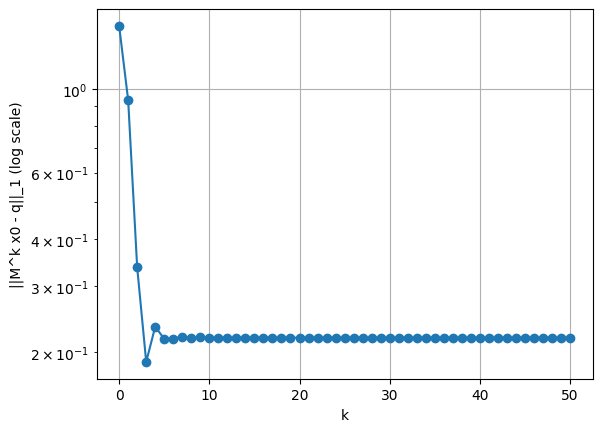

In [11]:
#tabella e grafico

rows = []
for k in ks:
    rows.append((k, norms[k], ratios[k]))
df = pd.DataFrame(rows, columns=["k", "||M^k x0 - q||_1", "ratio to prev"])
display(df)

# grafico logaritmico dell'errore per k=0..50
errs = [np.sum(np.abs(vecs[k] - q)) for k in range(0, max(ks)+1)]
plt.semilogy(range(len(errs)), errs, marker='o')
plt.xlabel('k')
plt.ylabel('||M^k x0 - q||_1 (log scale)')
plt.grid(True)
plt.show()

In [ ]:
#CONFRONTI CHE POTREI FARE: 
# SCELTA X0 DIVERSA
# confronti tra i rapporti e lambda 2
# confronto c e lambda2
# forse anche io qualcosa con dampling
